<a href="https://colab.research.google.com/github/BenjamTorr/TDA_DeepL_TimeSeries/blob/main/Earthquake_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U giotto-tda
from scipy.io import arff
import pandas as pd
import numpy as np
def load():
  data_train = arff.loadarff('drive/MyDrive/Data-Time_Series/Earthquakes_TRAIN.arff')
  df_train = pd.DataFrame(data_train[0])

  x_train = df_train.to_numpy()
  y_train = x_train[:,-1]
  y_train = [y_train[i][0] - 49 for i in range(len(y_train))]
  y_train = np.transpose(np.array(y_train))

  data_test = arff.loadarff('drive/MyDrive/Data-Time_Series/Earthquakes_TEST.arff')
  df_test = pd.DataFrame(data_test[0])

  x_test = df_test.to_numpy()
  y_test = x_test[:,-1]

  y_test = [y_test[i][0] - 49 for i in range(len(y_test))]
  x_test[1,:-1]

  X_test = [x_test[i,:-1] for i in range(len(x_test))]
  X_train = [x_train[i,:-1] for i in range(len(x_train))]
  return X_train, y_train, X_test, y_test


In [ ]:
import gtda
from gtda.time_series import TakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import BettiCurve


def get_betti_seq(X_train, X_test):
  TE = TakensEmbedding(time_delay=1, dimension=3)
  Embd_train = TE.fit_transform(X_train)
  Embd_test = TE.fit_transform(X_test)

  VR_train = VietorisRipsPersistence(homology_dimensions=(0,1,2))
  Xt = VR_train.fit_transform(Embd_train)
  VR_test = VietorisRipsPersistence(homology_dimensions=(0,1,2))
  Xtr = VR_test.fit_transform(Embd_test)

  BC_train = BettiCurve(n_bins = 200)
  X_betti_curves_train = BC_train.fit_transform(Xt)
  BC_test = BettiCurve(n_bins = 200)
  X_betti_curves_test = BC_test.fit_transform(Xtr)

  X_betti_seq_train = [np.concatenate([X_betti_curves_train[i,0], X_betti_curves_train[i,1], X_betti_curves_train[i,2]]) for i in range(len(X_betti_curves_train))]
  X_betti_seq_test = [np.concatenate([X_betti_curves_test[i,0], X_betti_curves_test[i,1], X_betti_curves_test[i,2]]) for i in range(len(X_betti_curves_test))]

  return X_betti_seq_train, X_betti_seq_test

# Esta parte solo se ejecuta la primera vez, después se guardan estos resultados

In [ ]:
X_train, y_train, X_test, y_test = load()
X_betti_seq_train, X_betti_seq_test = get_betti_seq(X_train, X_test)


In [ ]:
a_file = open("drive/MyDrive/Data-Time_Series/betti_seq_eart_tr.txt", "w")
for row in X_betti_seq_train:
  np.savetxt(a_file,row)
a_file.close()

a_file = open("drive/MyDrive/Data-Time_Series/betti_seq_eart_te.txt", "w")
for row in X_betti_seq_test:
  np.savetxt(a_file,row)
a_file.close()


# Como ya se ha ejecutado el código una vez y crear las secuencias de Betti es bastante tardado las guardamos y las volvemos a cargar

In [ ]:
X_betti_seq_trainSi = np.loadtxt('drive/MyDrive/Data-Time_Series/betti_seq_eart_tr.txt')
X_betti_seq_testSi = np.loadtxt('drive/MyDrive/Data-Time_Series/betti_seq_eart_te.txt')

X_betti_seq_test = X_betti_seq_testSi.reshape(139, 600)
X_betti_seq_train = X_betti_seq_trainSi.reshape(322, 600)

In [92]:
y_test1 = y_test + np.ones(len(y_test))
y_train1 = y_train + np.ones(len(y_train))


In [ ]:
X_betti_seq_val = np.array(X_betti_seq_train[:80])
X_betti_seq_trainR = np.array(X_betti_seq_train[80:])
y_val = np.array(y_train1[:80])
y_trainR = np.array(y_train1[80:])
X_betti_seq_val.shape

X_betti_seq_val = np.expand_dims(X_betti_seq_val, axis=-1)
X_betti_seq_trainR = np.expand_dims(X_betti_seq_trainR, axis=-1)

X_betti_seq_testR = np.array(X_betti_seq_test)
y_testR = np.array(y_test1)
X_betti_seq_testR = np.expand_dims(X_betti_seq_test, axis=-1)

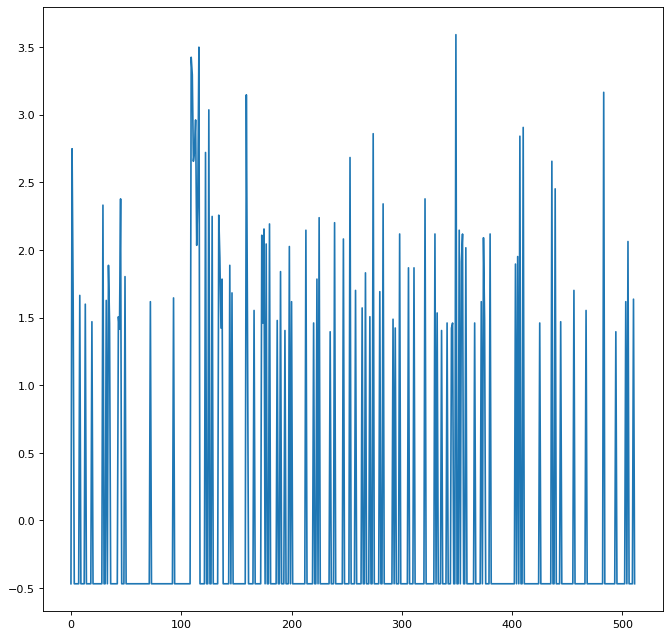

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)

plt.plot(X_test[1])

# Notamos que las clases están desbalanceadas terriblemente

In [ ]:
s = 0
for a in y_train1:
  if(a == 0):
    s = s + 1
s

264

# Creamos el modelo  tratando de obtener el mejor modelo y asignando pesos a las clases

In [ ]:
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import class_weight
def evaluar_modelo(X_betti_seq_train, y_train, X_betti_seq_test, y_test, X_betti_seq_val, y_val, verbose1):
  model = keras.models.Sequential([
      keras.layers.Conv1D(64, 7, activation="relu", padding="same", input_shape=(600, 1)),
      keras.layers.Conv1D(64, 5, activation="relu", padding="same"),
      keras.layers.Dropout(0.5),
      keras.layers.MaxPooling1D(3, padding="same"),
      keras.layers.Flatten(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(100, activation="relu", activity_regularizer=tf.keras.regularizers.l2(0.04)),
      keras.layers.Dense(2, activation="softmax")
  ])
  opt = tf.keras.optimizers.SGD(learning_rate=0.00001)
  opt2 = tf.keras.optimizers.Adam(learning_rate=0.00005)
  model.compile(loss = "categorical_crossentropy", optimizer=opt2, metrics=["accuracy"])
  class_weight = {0: 1.,
                1: 3.}
  history = model.fit(X_betti_seq_train, y_train, epochs=80, validation_data=(X_betti_seq_val, y_val), verbose = verbose1, class_weight=class_weight)
  a,acc = model.evaluate(X_betti_seq_test, y_test)
  #history = model.fit(X_betti_seq_train, y_train, epochs=70, validation_data=(X_betti_seq_test, y_test), verbose = verbose1)
  #a,acc = model.evaluate(X_betti_seq_val, y_val)
  return history, acc, model

In [ ]:
X_betti_seq_testC = np.expand_dims(X_betti_seq_test, axis=-1);
X_betti_seq_trainC = np.expand_dims(X_betti_seq_train, axis=-1)
X_betti_seq_trainC.shape

(322, 600, 1)

In [ ]:
y_tes = keras.utils.to_categorical(y_testR)
y_tra = keras.utils.to_categorical(y_trainR)
y_v = keras.utils.to_categorical(y_val)

In [ ]:
history, acc, model = evaluar_modelo(X_betti_seq_trainR, y_tra, X_betti_seq_testR, y_tes, X_betti_seq_val, y_v, 1)
acc

Epoch 1/80
8/8 [==============================] - 1s 108ms/step - loss: 23.0176 - accuracy: 0.3636 - val_loss: 4.4910 - val_accuracy: 0.3250
Epoch 2/80
8/8 [==============================] - 1s 87ms/step - loss: 11.0952 - accuracy: 0.5909 - val_loss: 2.2301 - val_accuracy: 0.3625
Epoch 3/80
8/8 [==============================] - 1s 83ms/step - loss: 6.0634 - accuracy: 0.5661 - val_loss: 1.3039 - val_accuracy: 0.3000
Epoch 4/80
8/8 [==============================] - 1s 87ms/step - loss: 3.5534 - accuracy: 0.5413 - val_loss: 0.8907 - val_accuracy: 0.5750
Epoch 5/80
8/8 [==============================] - 1s 86ms/step - loss: 2.2566 - accuracy: 0.5744 - val_loss: 0.7524 - val_accuracy: 0.7750
Epoch 6/80
8/8 [==============================] - 1s 84ms/step - loss: 1.7354 - accuracy: 0.6157 - val_loss: 0.7100 - val_accuracy: 0.8000
Epoch 7/80
8/8 [==============================] - 1s 82ms/step - loss: 1.4218 - accuracy: 0.6364 - val_loss: 0.6941 - val_accuracy: 0.8000
Epoch 8/80
8/8 [========

0.7482014298439026

<function matplotlib.pyplot.show>

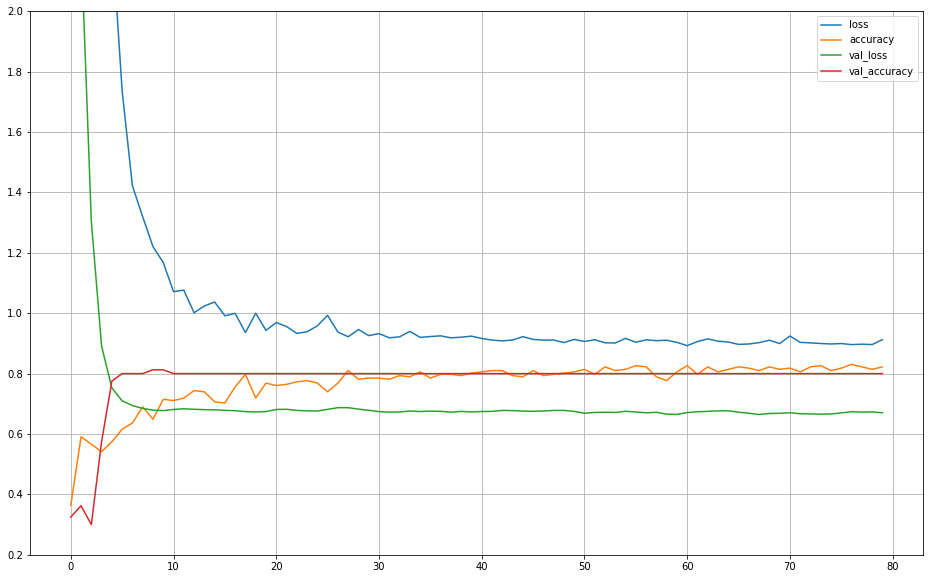

In [ ]:
from matplotlib import pyplot as plt
pd.DataFrame(history.history).plot(figsize=(16,10))
plt.grid(True)
plt.gca().set_ylim(0.2,2)
plt.show

In [ ]:
y_pred = model.predict(X_betti_seq_testR)

import plotly.express as px

CM = tf.math.confusion_matrix(y_pred.argmax(axis=1), y_tes.argmax(axis=1))

fig = px.imshow(CM)
fig.show()